<h1><center><font size="6">Pretrained Models Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>ResNet50</a>
    - <a href='#21'>Generating the Datasets</a> 
    - <a href='#22'>Constructing the Model</a> 
    - <a href='#24'>Training the Model</a>     
    - <a href='#25'>Evaluating the Model</a> 
    - <a href='#26'>Predicting on Holdout Set</a>
- <a href='#3'>AlexNet</a> 
    - <a href='#31'>Generating the Datasets</a> 
    - <a href='#32'>Constructing the Model</a> 
    - <a href='#34'>Training the Model</a>     
    - <a href='#35'>Evaluating the Model</a> 
    - <a href='#36'>Predicting on Holdout Set</a> 
- <a href='#4'>VGG19</a>    
    - <a href='#41'>Generating the Datasets</a> 
    - <a href='#42'>Constructing the Model</a> 
    - <a href='#43'>Training the Model</a> 
    - <a href='#44'>Evaluating the Model</a> 
    - <a href='#45'>Predicting on Holdout Set</a>
  


# <a id='1'>Importing Packages</a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import datetime
import itertools 
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

%reload_ext autoreload
%autoreload 2
from utils import *

# <a id='2'>ResNet50 Architecture</a>

Transfer learning is a machine learning method in which we build a neural network off of an already pre-trained neural network.

<center><img src="../images/resnet50.jpg"></center>

## <a id='21'>Generating the Datasets</a>

In [2]:
# Set path for training testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='22'>Constructing the Model</a>

In [4]:
# model creation
cnn_base = ResNet50(include_top = False,
                    weights = "imagenet",
                    input_shape = (256, 256, 3))
model = models.Sequential()
model.add(cnn_base)
model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))

cnn_base.trainable = False

In [5]:
# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [15]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_resnet/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_resnet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_resnet/log.csv')

## <a id='25'>Training the Model</a>


In [16]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, earlyStopping, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 1818s 4s/step - loss: 0.5527 - accuracy: 0.7607 - precision: 0.7607 - recall: 1.0000 - auc: 0.4971 - auc_1: 0.7583 - val_loss: 0.4427 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8644

Epoch 00001: saving model to ../logs/log_resnet/model.01-0.44.hdf5
Epoch 2/20
427/427 [==============================] - 1828s 4s/step - loss: 0.5519 - accuracy: 0.7610 - precision: 0.7610 - recall: 1.0000 - auc: 0.4917 - auc_1: 0.7617 - val_loss: 0.4295 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8644

Epoch 00002: saving model to ../logs/log_resnet/model.02-0.43.hdf5
Epoch 3/20
427/427 [==============================] - 1933s 5s/step - loss: 0.5518 - accuracy: 0.7610 - precision: 0.7610 - recall: 1.0000 - auc: 0.4955 - auc_1: 0.7590 - val_loss: 0.4395 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - 

## <a id='26'>Evaluating the Model</a>


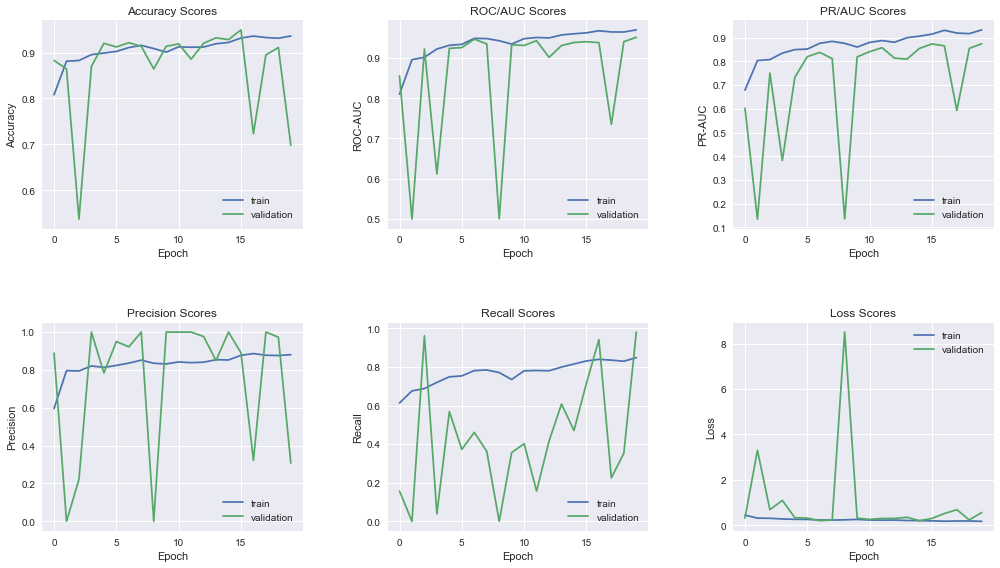

In [4]:
# visualization of the metrics tracked during training
plt.style.use('seaborn')
history = pd.read_csv("../logs/log_resnet_2/log.csv")
sixplot2(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [5]:
# display dataframe of the metrics per epoch
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.808177,0.810237,0.678885,0.448274,0.001000,0.595948,0.613121,0.882979,0.855581,0.602806,0.319932,0.888889,0.156863
1,1,0.881155,0.896027,0.803790,0.315941,0.001000,0.796243,0.675659,0.864362,0.499231,0.134621,3.302433,0.000000,0.000000
2,2,0.882758,0.901957,0.808061,0.309302,0.001000,0.794346,0.687882,0.537234,0.922466,0.751028,0.688484,0.221719,0.960784
3,3,0.895516,0.922524,0.835329,0.278720,0.001000,0.820979,0.719804,0.869681,0.611523,0.382377,1.097795,1.000000,0.039216
4,4,0.898886,0.931776,0.850095,0.264280,0.000500,0.813333,0.748466,0.920213,0.924299,0.732930,0.334531,0.783784,0.568627
5,5,0.902550,0.934187,0.852277,0.258687,0.000500,0.823608,0.753374,0.912234,0.926041,0.820359,0.317262,0.950000,0.372549
6,6,0.910903,0.949021,0.876725,0.233647,0.000500,0.835958,0.780637,0.921543,0.947179,0.838203,0.201120,0.921569,0.460784
7,7,0.915739,0.948476,0.884942,0.230893,0.000500,0.851531,0.784181,0.913564,0.935249,0.812246,0.234218,1.000000,0.362745
8,8,0.908851,0.943090,0.876542,0.241399,0.000500,0.835106,0.770552,0.864362,0.500000,0.135638,8.508089,0.000000,0.000000
9,9,0.900938,0.934860,0.860988,0.259033,0.000500,0.831484,0.734681,0.913564,0.933066,0.819475,0.314942,1.000000,0.356436


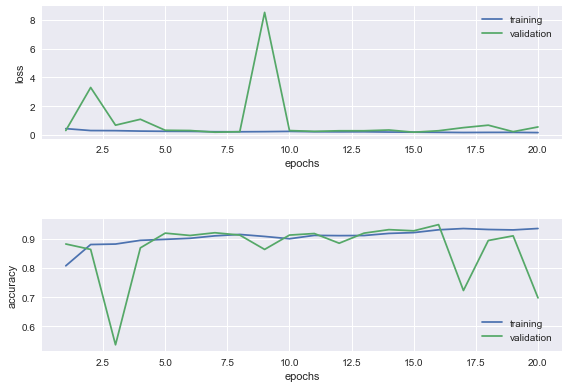

In [6]:
# visualize loss and accuracy
train_val_metrics2(20, history)

In [7]:
model = load_model("../logs/log_resnet_2/model.15-0.20.hdf5")

## <a id='27'>Predicting on Holdout Set</a>

In [34]:
# get testing loss and accuracy
test_generator.reset()
score = model2.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

1/1 [==============================] - 2s 2s/step - loss: 1.3920 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - auc_1: 0.0000e+00
loss: 1.392035961151123
accuracy: 0.0


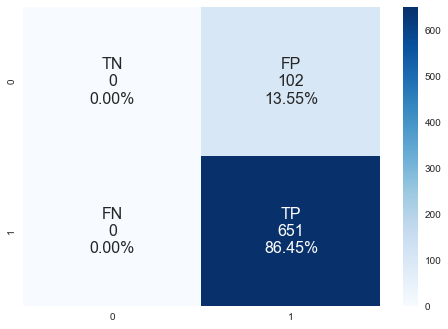

In [28]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

# <a id='3'>AlexNet Architecture</a>


## <a id='31'>Generating the Datasets</a>

In [2]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (227, 227),
        batch_size = 1,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='32'>Constructing the Model</a>

In [6]:
# construct model
model2 = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile model
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', Precision(), Recall(), AUC(), AUC(curve='PR')])

In [7]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
filepath = "../logs/log_alexnet2/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_alexnet2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_alexnet2/log.csv')

## <a id='34'>Training the Model</a>

In [42]:
# train model
history2 = model2.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 4282s 10s/step - loss: 7.8137 - accuracy: 0.8608 - precision_1: 0.9090 - recall_1: 0.9079 - auc_2: 0.8322 - auc_3: 0.9125 - val_loss: 0.3881 - val_accuracy: 0.9109 - val_precision_1: 0.9206 - val_recall_1: 0.9815 - val_auc_2: 0.8884 - val_auc_3: 0.9698

Epoch 00001: saving model to ../logs/log_alexnet/weights-improvement-01-0.39.hdf5
Epoch 2/20
427/427 [==============================] - 4929s 12s/step - loss: 0.6389 - accuracy: 0.8910 - precision_1: 0.9236 - recall_1: 0.9339 - auc_2: 0.9120 - auc_3: 0.9557 - val_loss: 0.2953 - val_accuracy: 0.9136 - val_precision_1: 0.9137 - val_recall_1: 0.9938 - val_auc_2: 0.9072 - val_auc_3: 0.9765

Epoch 00002: saving model to ../logs/log_alexnet/weights-improvement-02-0.30.hdf5
Epoch 3/20
427/427 [==============================] - 4970s 12s/step - loss: 0.4187 - accuracy: 0.8980 - precision_1: 0.9234 - recall_1: 0.9443 - auc_2: 0.9277 - auc_3: 0.9657 - val_loss: 0.3824 - val_accuracy: 0.9362 - 

## <a id='35'>Evaluating the Model</a>

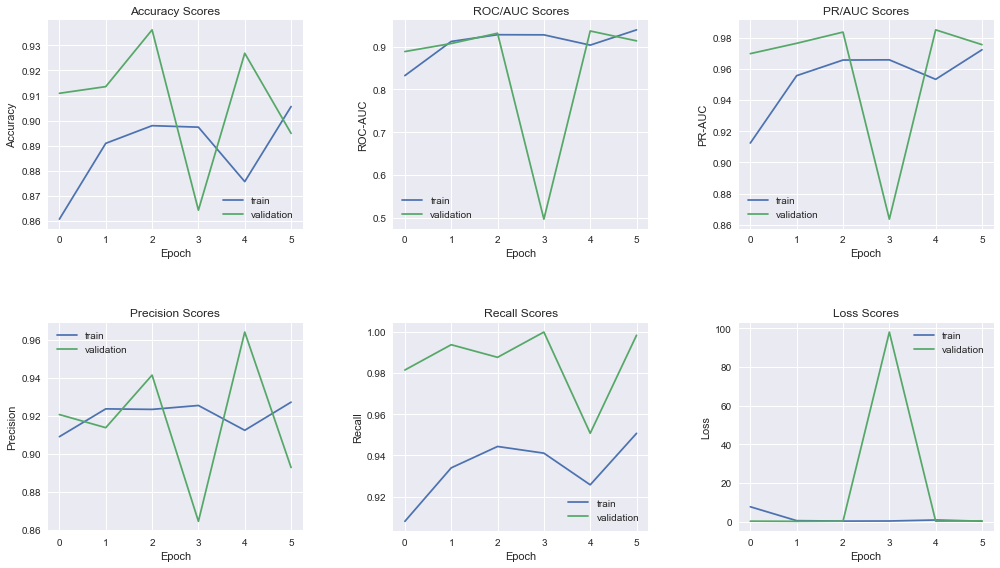

In [43]:
# visualize metrics measured
plt.style.use('seaborn')
history2 = pd.read_csv()
sixplot(history2, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [44]:
# display dataframe of metriccs
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_1,recall_1,auc_2,auc_3,val_loss,val_accuracy,val_precision_1,val_recall_1,val_auc_2,val_auc_3,lr
0,7.813650,0.860785,0.908986,0.907935,0.832246,0.912480,0.388073,0.910904,0.920635,0.981538,0.888416,0.969848,0.001
1,0.638907,0.890973,0.923634,0.933950,0.912006,0.955711,0.295269,0.913564,0.913720,0.993846,0.907172,0.976474,0.001
2,0.418699,0.898007,0.923367,0.944348,0.927745,0.965739,0.382426,0.936170,0.941435,0.987711,0.931248,0.983664,0.001
3,0.464771,0.897421,0.925421,0.941097,0.927415,0.965859,98.079224,0.864362,0.864362,1.000000,0.496923,0.863639,0.001
4,0.985056,0.875733,0.912351,0.925698,0.903431,0.953363,0.383877,0.926862,0.964119,0.950769,0.936433,0.985103,0.001
5,0.366652,0.905627,0.927177,0.950731,0.939079,0.972340,0.544970,0.894947,0.892710,0.998462,0.913356,0.975612,0.001


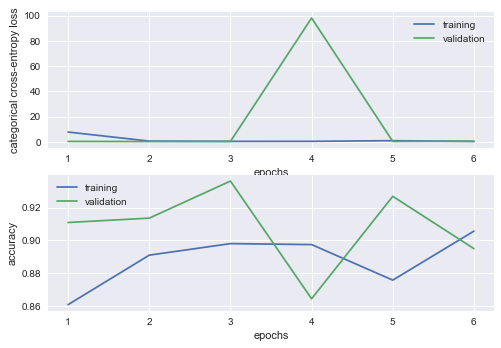

In [71]:
# display accuracy and loss for testing set
plt.style.use('seaborn')
train_val_metrics(6, history2)

## <a id='36'>Predicting on Holdout Set</a>

In [49]:
# get testing accuracy and loss
score = model2.evaluate_generator(test_generator, verbose = 1)

print(str("Loss: " + str(score[0]))
print(str("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))


753/753 [==============================] - 106s 141ms/step - loss: 0.9815 - accuracy: 0.9004 - precision_1: 0.8967 - recall_1: 1.0000 - auc_2: 0.8769 - auc_3: 0.9658
loss: 0.9815390706062317
accuracy: 0.9003984332084656


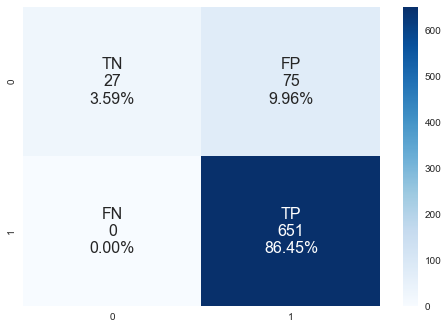

In [48]:
# create confusion matrix visualization
test_generator.reset()
y_pred = model2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_2 = prob2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

# <a id='4'>VGG19 Architecture</a>



## <a id='41'>Generating the Datasets</a>

In [7]:
# generate datasets
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        batch_size = 1,
        seed = 42,
        shuffle = False)

STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='42'>Constructing the Model</a>

In [11]:
# construct model
vgg_19 = VGG19(include_top = False, 
               weights = 'imagenet', 
               input_shape = (224, 224, 3))

vgg_19.trainable = False

model3 = Sequential([
    vgg_19,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile model
model3.compile(optimizer = Adam(lr = 0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

In [12]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_vgg19_2/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_vgg19_2/log.csv')
log_dir = "../logs/log_vgg19_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## <a id='43'>Training the Model</a>

In [5]:
# train model
history3 = model3.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
684/684 [==============================] - 4620s 7s/step - loss: 0.3717 - accuracy: 0.8896 - auc: 0.9037 - auc_1: 0.8556 - precision: 0.7991 - recall: 0.7382 - val_loss: 0.1690 - val_accuracy: 0.9347 - val_auc: 0.9544 - val_auc_1: 0.8620 - val_precision: 0.8955 - val_recall: 0.5882

Epoch 00001: saving model to ../logs/log_vgg19_2/model.01-0.17.hdf5
Epoch 2/20
495/684 [====================>.........] - ETA: 8:28 - loss: 0.1404 - accuracy: 0.9468 - auc: 0.9751 - auc_1: 0.9564 - precision: 0.9330 - recall: 0.8391

KeyboardInterrupt: 

## <a id='44'>Evaluating the Model</a>

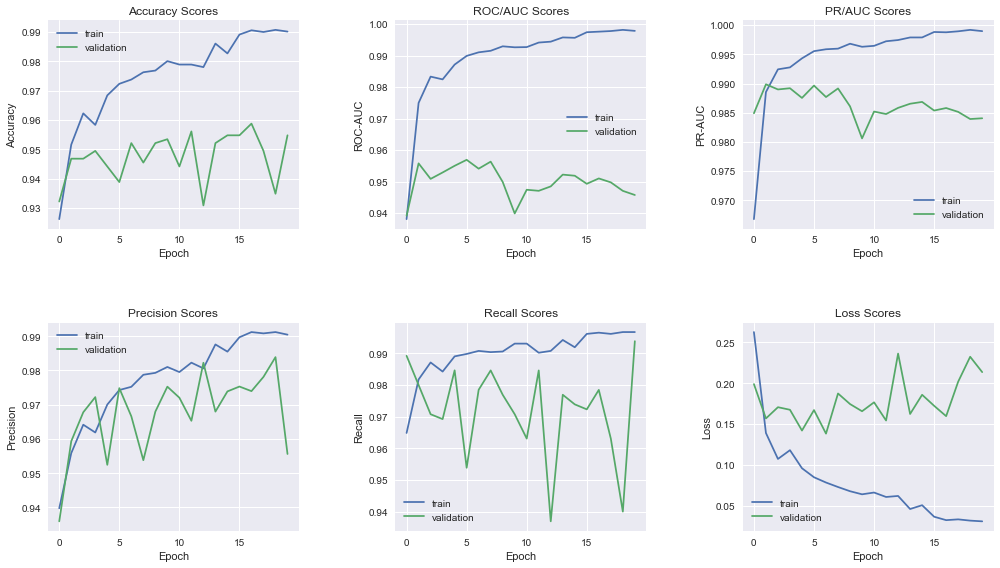

In [60]:
# evaluate model 
plt.style.use('seaborn')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [61]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3,lr
0,0.262785,0.926170,0.938105,0.966774,0.939757,0.964848,0.199009,0.932181,0.939201,0.984906,0.935953,0.989231,0.0010
1,0.139081,0.951608,0.975001,0.988541,0.955863,0.981752,0.156916,0.946809,0.955807,0.989868,0.959337,0.980000,0.0010
2,0.107300,0.962281,0.983352,0.992432,0.964165,0.987130,0.170709,0.946809,0.950882,0.988987,0.967791,0.970769,0.0010
3,0.118029,0.958333,0.982473,0.992768,0.961892,0.984249,0.167556,0.949468,0.952919,0.989195,0.972222,0.969231,0.0010
4,0.095900,0.968421,0.987176,0.994314,0.970045,0.989051,0.142086,0.944149,0.955035,0.987535,0.952452,0.984639,0.0010
5,0.084858,0.972368,0.989928,0.995546,0.974286,0.989819,0.167189,0.938830,0.956938,0.989651,0.974843,0.953846,0.0010
6,0.078395,0.973830,0.991065,0.995871,0.975232,0.990780,0.138321,0.952128,0.954122,0.987688,0.966616,0.978495,0.0010
7,0.072894,0.976316,0.991553,0.995977,0.978740,0.990396,0.187529,0.945479,0.956357,0.989160,0.953800,0.984615,0.0010
8,0.067746,0.976901,0.992972,0.996820,0.979301,0.990588,0.174568,0.952128,0.949917,0.986094,0.967988,0.976923,0.0010
9,0.063952,0.980117,0.992658,0.996297,0.981025,0.993085,0.165739,0.953457,0.939910,0.980603,0.975270,0.970769,0.0010


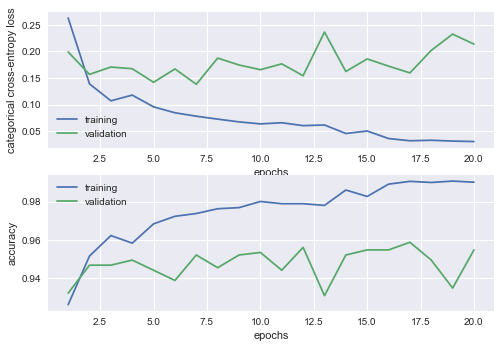

In [62]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

## <a id='45'>Predicting on Test Set</a>

In [65]:
test_generator.reset()
score = model3.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))


753/753 [==============================] - 720s 957ms/step - loss: 0.2187 - accuracy: 0.9668 - auc_6: 0.9243 - auc_7: 0.9771 - precision_3: 0.9644 - recall_3: 0.9985
Loss: 0.21871446073055267
Accuracy: 0.9667994976043701
Precision: 0.9242868423461914
Recall: 0.9771350026130676
ROC-AUC: 0.9643917083740234
PR-AUC: 0.9984639286994934


753/753 [==============================] - 665s 884ms/step


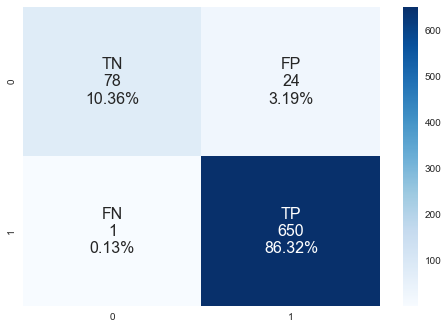

In [68]:
test_generator.reset()
prob3 = model3.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred_3)